# Gaussian Mixture Model (GMM) Outlier Classifier
Here we utilize a GMM for a classification task.
Only latent space elements near gaussians are considered in the classification.
Other points are assigned to a special outlier class.

We optimize both, the projection of input tensors onto a low dimensional (e.g., 2) latent space,
as well as the parameters of the GMM which is then used, to classify the data from their latent space representation.

With this we hope, that clusters of similar data points will form in the latent space which are reminiscent of the associated gaussian pdf for that class.

## Setup

### Pre-sets

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import tensorflow.keras as tk
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import math

### Load MNIST Dataset

In [3]:
mnist = tk.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


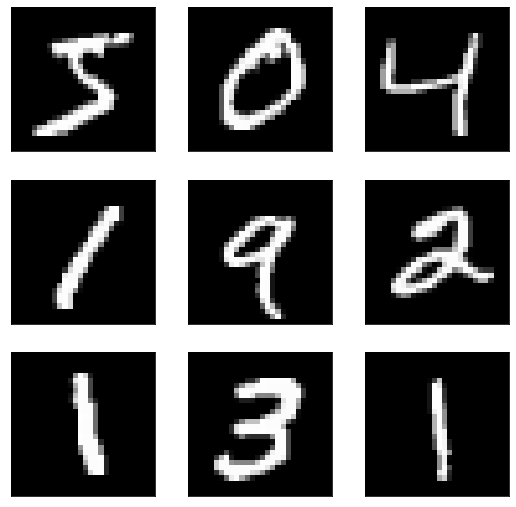

In [4]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
plt.figure(figsize=(9,9))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.xticks([]); plt.yticks([])
# show the figure
plt.show()

### Transform labels to classes and outliers
Elements assigned to categories can be provided as list via the `valid` argument.
All other values of the labels will be assigned to the outliers class.
The labels will be relabeled to starting from `[0, n, n+1]`, where `0` to `n` are assigned to the former labels, and `n+1` to the outlier class.

In [5]:
def transform_labels(y_label, valid=[0, 1], default=-1, relabel=True):
    labels = np.unique(y_label)    
    y_labels_trafo = np.copy(y_label)
    for l in labels:
        if l not in valid:
            yi = np.where(y_label == l)[0]
            y_labels_trafo[yi] = default
    
    if not relabel:
        return y_labels_trafo
    
    new_labels = np.unique(y_labels_trafo)
    relabelings = [np.where(y_labels_trafo == l)[0] for l in new_labels]
    for i, r in enumerate(relabelings):
        y_labels_trafo[r] = i

    return y_labels_trafo, new_labels

In [6]:
valid = [1, 4, 7]

y_train_outliers, mapping = transform_labels(y_train, valid=valid, default=-1, relabel=True)
y_test_outliers, __ = transform_labels(y_test, valid=valid, default=-1, relabel=True)

for i, label in enumerate(mapping):
    print(f"category {i} mask label {label}")
    
print('\nmasked labeling:', y_train_outliers)

category 0 mask label 1
category 1 mask label 4
category 2 mask label 7
category 3 mask label 255

masked labeling: [3 3 1 ... 3 3 3]


In [7]:
y_train_cat = tk.utils.to_categorical(y_train_outliers)
y_test_cat = tk.utils.to_categorical(y_test_outliers)

y_train_cat

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [8]:
for i, label in enumerate(mapping):
    print(f"category {i} with mask label {label} has {int(y_train_cat[:, i].sum())} training and {int(y_test_cat[:, i].sum())} test elements.")


category 0 with mask label 1 has 6742 training and 1135 test elements.
category 1 with mask label 4 has 5842 training and 982 test elements.
category 2 with mask label 7 has 6265 training and 1028 test elements.
category 3 with mask label 255 has 41151 training and 6855 test elements.


## The GMM Layer

In [9]:
class GMM(tk.layers.Layer):
    def __init__(self, input_dim, n_classes, name='gmm'):
        super(GMM, self).__init__(name=name)
        self.w = self.add_weight(shape=(n_classes,), initializer='random_normal', trainable=True, name='w')
        self.mu = self.add_weight(shape=(input_dim, n_classes), initializer='random_normal', trainable=True, name='mu')
        self.sigma = self.add_weight(shape=(n_classes,), initializer='ones', trainable=False, name='sigma')
        
        self.norm = 1./(tf.math.sqrt(self.sigma*2.*math.pi))
        self.epsilon = 1e-6
        self.relu = tk.layers.ReLU()

    def gaussian_pdf(self, x):
        x = x[..., None]  # extend by class dim
        mu_sq_dist = tk.backend.sum((x-self.mu)**2, axis=-2)  # sum along distance dim
        return tf.math.exp(-0.5*mu_sq_dist/(self.sigma**2))*self.norm        
        
    def call(self, x):
        pdf = self.gaussian_pdf(x)              # probability density (pdf) evaluated at x
        
        # scale for pdf -> probability of x being sampled from k-th gaussian
        w_k = tf.math.abs(self.w)
        norm = tk.backend.sum(pdf * w_k, axis=-1)
        p_k = w_k * pdf / (norm[..., None] + self.epsilon)  # pdf -> p_k = w_k * pdf_k(x) / [sum_j w_j * pdf_j(x)]
        
        outliers = self.relu(1. - tk.backend.sum(p_k, axis=-1)[..., None])
        return tf.concat([p_k, outliers], axis=-1)


x = tf.ones((3,2))  # BATCH-SIZE x LATENT-DIM
print("input-shape (BATCH-SIZE x LATENT-DIM):", x.shape)
print("input:\n", x)

gmm = GMM(2, 2)     # LATENT-DIM x NUM-CLASSES
print("\nGaussian-Mixture-Model (LATENT-DIM, NUM-CLASSES):", gmm.mu.shape)
y = gmm(x)

print("\noutput-shape (BATCH-SIZE x [NUM-CLASSES + 1]):", y.shape)
print("output:\n", y)


input-shape (BATCH-SIZE x LATENT-DIM): (3, 2)
input:
 tf.Tensor(
[[1. 1.]
 [1. 1.]
 [1. 1.]], shape=(3, 2), dtype=float32)

Gaussian-Mixture-Model (LATENT-DIM, NUM-CLASSES): (2, 2)

output-shape (BATCH-SIZE x [NUM-CLASSES + 1]): (3, 3)
output:
 tf.Tensor(
[[5.5087876e-01 4.4905165e-01 6.9618225e-05]
 [5.5087876e-01 4.4905165e-01 6.9618225e-05]
 [5.5087876e-01 4.4905165e-01 6.9618225e-05]], shape=(3, 3), dtype=float32)


2022-03-23 18:08:27.629697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 18:08:27.657746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-23 18:08:27.657763: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-23 18:08:27.658227: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

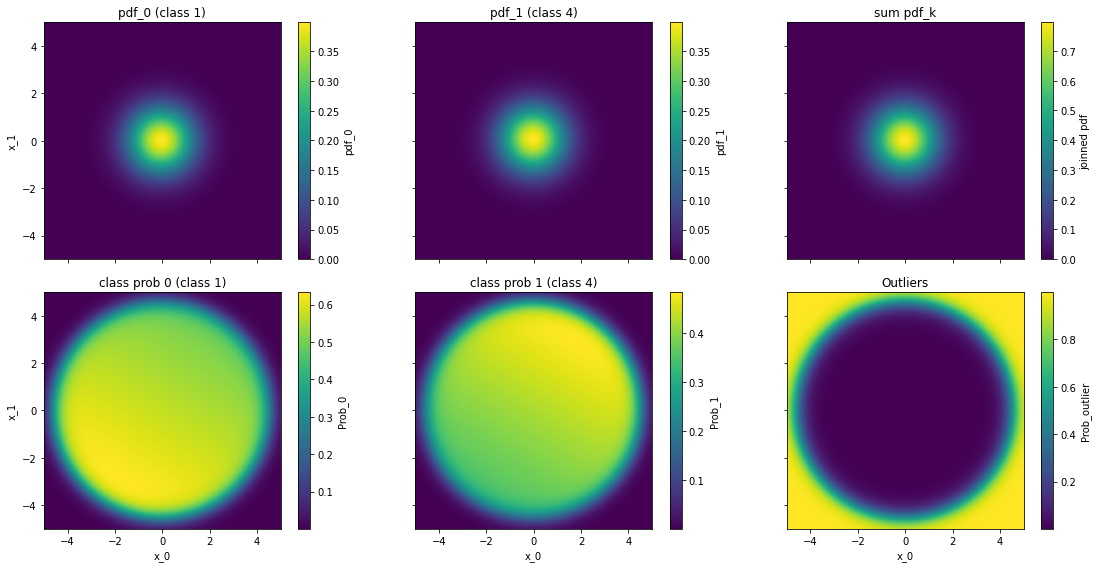

In [10]:
def show_latent_2d(gmm, xy_min=-5, xy_max=5, n=101):
    x = np.linspace(xy_min, xy_max, n)
    y = np.linspace(xy_min, xy_max, n)

    xy = np.array(list(it.product(x, y)))
    pdf = gmm.gaussian_pdf(xy)
    pk = gmm(xy)

    n_pdfs = pdf.shape[-1]
    f, [axes_pdf, axes_pk] = plt.subplots(2, n_pdfs + 1, figsize=(16, 8), sharex=True, sharey=True)
    for k in range(n_pdfs):
        cb = axes_pdf[k].imshow(pdf[...,k].numpy().reshape((len(x), len(y))), extent=(x[0], x[-1], y[-1], y[0]))
        axes_pdf[k].set_title(f"pdf_{k} (class {mapping[k]})")
        axes_pdf[k].invert_yaxis()
        plt.colorbar(cb, ax=axes_pdf[k], label=f'pdf_{k}')

        cb  = axes_pk[k].imshow(pk[...,k].numpy().reshape((len(x), len(y))), extent=(x[0], x[-1], y[-1], y[0]))
        axes_pk[k].set_title(f"class prob {k} (class {mapping[k]})")
        axes_pk[k].set_xlabel("x_0")
        axes_pk[k].invert_yaxis()
        plt.colorbar(cb, ax=axes_pk[k], label=f'Prob_{k}')

    cb = axes_pdf[-1].imshow(pdf.numpy().sum(axis=-1).reshape((len(x), len(y))), extent=(x[0], x[-1], y[-1], y[0]))
    axes_pdf[-1].set_title("sum pdf_k")
    plt.colorbar(cb, ax=axes_pdf[-1], label=f'joinned pdf')
    axes_pdf[0].set_ylabel("x_1")
    axes_pdf[0].invert_yaxis()

    cb = axes_pk[-1].imshow(pk[...,-1].numpy().reshape((len(x), len(y))), extent=(x[0], x[-1], y[-1], y[0]))
    axes_pk[-1].set_title("Outliers")
    plt.colorbar(cb, ax=axes_pk[-1], label=f'Prob_outlier')
    axes_pk[0].set_ylabel("x_1")
    axes_pk[-1].set_xlabel("x_0")
    axes_pk[-1].invert_yaxis()

    plt.tight_layout()

show_latent_2d(gmm)

## The Model

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense

gm_model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
gm_model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
gm_model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
gm_model.add(MaxPooling2D(pool_size=(2,2)))
gm_model.add(BatchNormalization())

gm_model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
gm_model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
gm_model.add(MaxPooling2D(pool_size=(2,2)))
gm_model.add(BatchNormalization())    
    
gm_model.add(Flatten())
gm_model.add(Dense(2, name='latent'))
gm_model.add(GMM(2, n_classes=len(valid), name='gmm'))
    
gm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
gm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

## Training

In [12]:
X, y = (x_train/255.)[..., None], y_train_cat
gm_model.fit(X, y, epochs=10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 62s 259ms/step - loss: 0.4000 - accuracy: 0.8997
Epoch 2/10
235/235 [==============================] - 61s 260ms/step - loss: 0.1449 - accuracy: 0.9771
Epoch 3/10
235/235 [==============================] - 61s 258ms/step - loss: 0.0800 - accuracy: 0.9852
Epoch 4/10
235/235 [==============================] - 61s 258ms/step - loss: 0.0534 - accuracy: 0.9896
Epoch 5/10
235/235 [==============================] - 61s 261ms/step - loss: 0.0413 - accuracy: 0.9917
Epoch 6/10
235/235 [==============================] - 62s 262ms/step - loss: 0.0325 - accuracy: 0.9929
Epoch 7/10
235/235 [==============================] - 62s 263ms/step - loss: 0.0271 - accuracy: 0.9938
Epoch 8/10
235/235 [==============================] - 62s 265ms/step - loss: 0.0183 - accuracy: 0.9960
Epoch 9/10
235/235 [==============================] - 62s 266ms/step - loss: 0.0144 - accuracy: 0.9969
Epoch 10/10
235/235 [==============================] - 62s 263ms/step - l

In [20]:
y_hat_cat = gm_model.predict((x_test/255.)[...,None])

In [14]:
y_hat = np.apply_along_axis(lambda i: mapping[i], -1, np.argmax(y_hat_cat, axis=-1))
y_true = np.apply_along_axis(lambda i: mapping[i], -1, y_test_outliers)

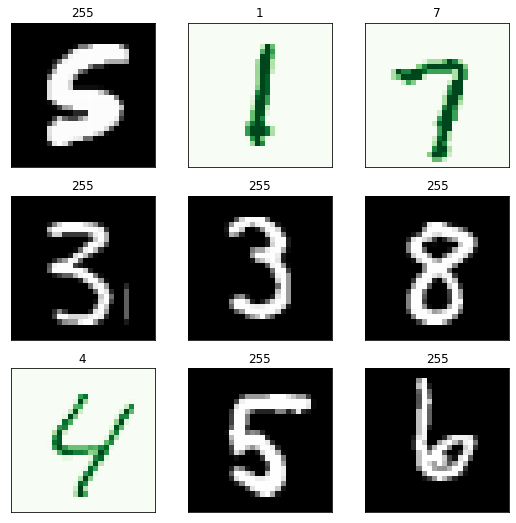

In [15]:
# summarize loaded dataset
# plot first few images
plt.figure(figsize=(9,9))
choice = np.random.choice(len(y_hat), size=9, replace=False)
for i, c in enumerate(choice):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    
    if y_hat[c] == y_true[c]:
        if y_hat[c] in valid:
            cmap = 'Greens'
        else:
            cmap = 'binary_r'
    else:
        cmap = 'Reds'
    
    plt.imshow(x_test[c], cmap=cmap)
    plt.title(y_hat[c])
    plt.xticks([]); plt.yticks([])
# show the figure
plt.show()

In [16]:
from tensorflow.keras import Model
input_layer = gm_model.input
output_layer = gm_model.get_layer('latent')
cluster_model = Model(input_layer, output_layer.output)

In [17]:
p = cluster_model.predict((x_test/255.)[...,None])
p.shape

(10000, 2)

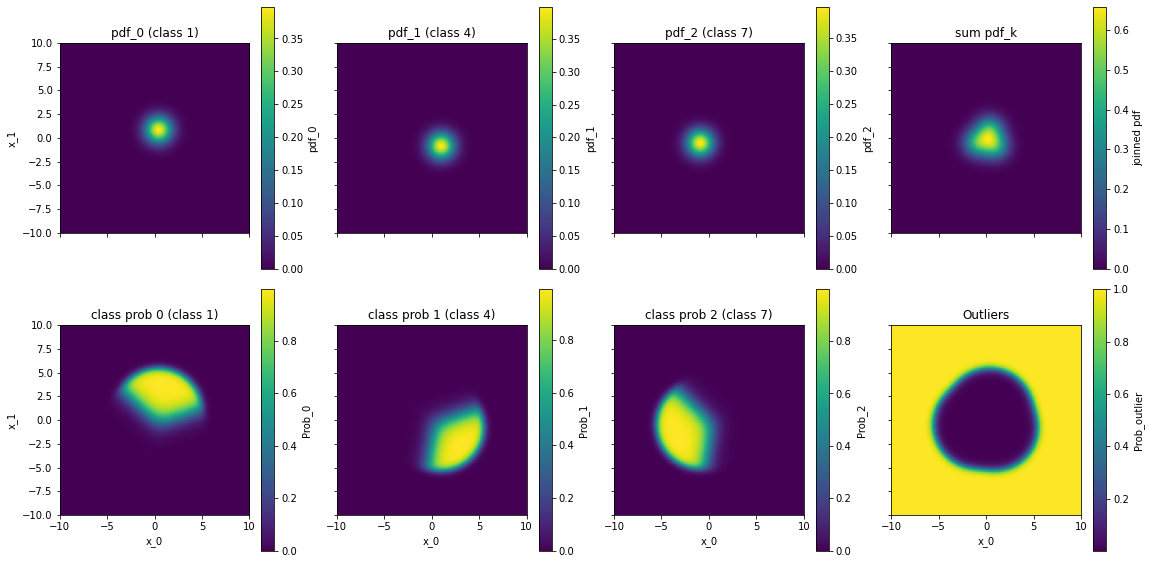

In [18]:
show_latent_2d(gm_model.get_layer('gmm'), xy_min=-10, xy_max=10)

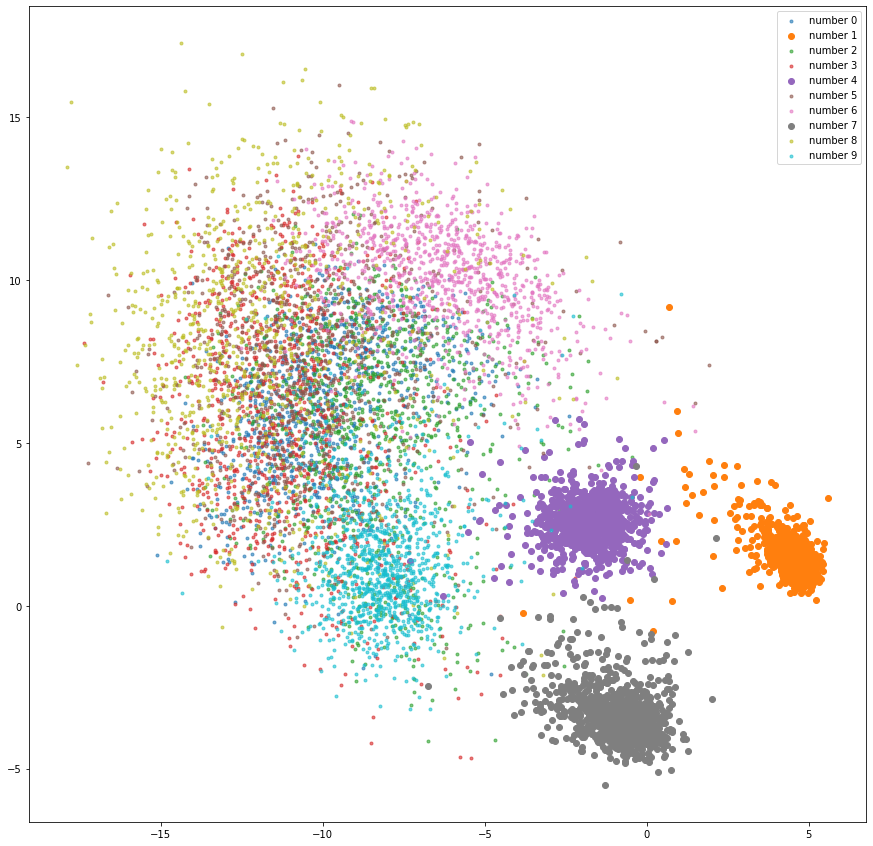

In [19]:
plt.figure(figsize=(15, 15))
for numeral in np.unique(y_test):
    i = (y_test == numeral)
    m = '.' if numeral not in valid else 'o'
    alpha = 0.6 if numeral not in valid else 1.
    plt.scatter(*p[i].T, label=f'number {numeral}', alpha=alpha, marker=m)

plt.legend()